# Using Jupyter Notebooks & Raytracer Specifics
_written by Jaren Ashcraft_

Talking to raytracers via their API's is not without its headaches. Jupyter Notebooks were not supported by Poke for some time because running the `trace_raysets` method would crash the Jupyter kernel.

In this tutorial we cover how to run Poke entirely from Jupyter notebooks to trace rays in Zemax and CODE V, as well as some other aspects of Poke that are raytracer specific

## Ansys Zemax OpticStudio
[Ansys Zemax OpticStudio (ZOS)](https://www.ansys.com/products/optics-vr/ansys-zemax-opticstudio?utm_source=google&utm_medium=ppc&utm_campaign=product&utm_content=digital_optics_opticsstudio-rsa_trial_request_search-ad_en_global&utm_term=zemax%20opticstudio&campaignid=7013g000000cXF7AAM&creative=643132945089&keyword=zemax%20opticstudio&matchtype=e&network=g&device=c&s_kwcid=AL!17240!3!643132945089!e!!g!!zemax%20opticstudio&gclid=CjwKCAjw38SoBhB6EiwA8EQVLsM_LHeRhgA2SUfIU9kpZWRUOotDApRJ3NYs1HW2UXxW3L1wN5xJFBoCfS8QAvD_BwE) is a commercial ray tracer that is fairly commonplace in astronomy, but is one of the "industry standard" ray tracers. ZOS is what Poke was originally built on, so we have a long(ish) history of working with its API. Before using Poke with ZOS there are a few things to note:

- Poke relies on the `Raytrace.dll` written by Michael Humphreys in [this Zemax Knowledgebase article](https://support.zemax.com/hc/en-us/articles/1500005576882-Batch-Processing-of-Ray-Trace-Data-using-ZOS-API-in-MATLAB-or-Python). Previously, to perform a batch ray trace one had to loop over the results which slowed the runtime considerably. The `Raytrace.dll` does this all in compiled C# code, so it is done much faster.

- Poke also utilized Michael Humphrey's [zosapi package](https://github.com/x68507/zosapi/), which essentially installs the ZOS-API boilerplate into your site-packages so that you don't have to copy it into every script that you want to write. This is installed when Poke is installed on your device.

Now, to use Poke with a ZOS optical system in Jupyter notebooks we will start by setting up a Rayfront with one of our example files.

In [1]:
from poke.poke_core import Rayfront

pth = "C:/Users/UASAL-OPTICS/Desktop/poke/test_files/PL&OS_CassegrainJonesPupil.zmx"

coating = 0.73677 + 1j*5.77450 # Al at 600nm
nrays = 64
wavelength = 0.6e-6
pupil_radius = 8323.3e-3/2
max_fov = 1e-3

# define surfaces
s1 = {
    'surf':1,
    'coating':coating,
    'mode':'reflect'
}

s2 = {
    'surf':2,
    'coating':coating,
    'mode':'reflect'
}

rf = Rayfront(nrays,wavelength,pupil_radius,max_fov)
rf.as_polarized([s1,s2])

norm fov =  [0. 0.]
base ray shape  (4, 3096)


Now we must initialize a connection to ZOS by importing the `zosapi` package

In [2]:
import zosapi
zos = zosapi.App() # establish the connection

We can then proceed to carry out our simulation as normal

In [3]:
rf.trace_rayset(pth)

tracing with global coordinates
tracing with global coordinates
1 Raysets traced through 2 surfaces


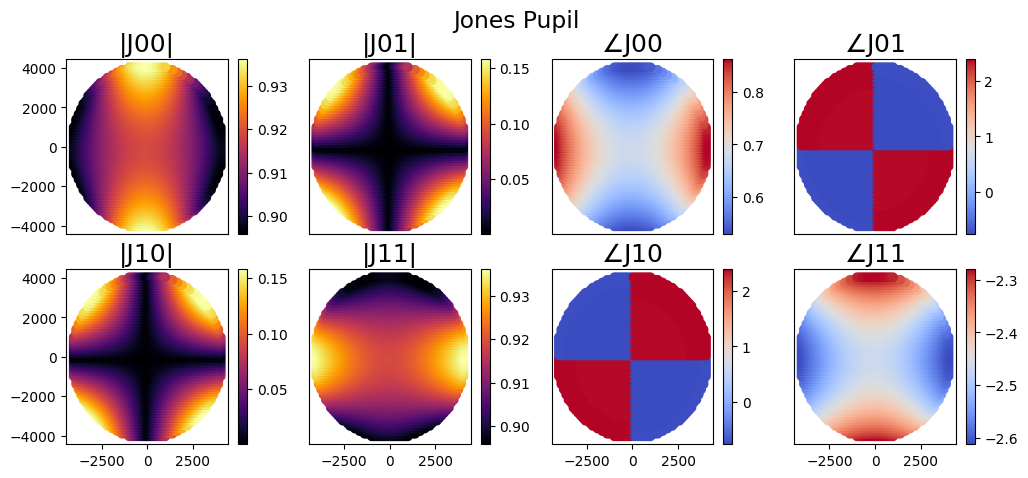

In [4]:
import poke.plotting as plot

# let's compute a Jones pupil
rf.compute_jones_pupil()
plot.jones_pupil(rf)

## SYNOPSYS CODE V
SYNOPSYS CODE V (CODE V) is another industry-standard commercial ray tracer, and the one that I learned lens design on. CODE V's Python API is COM-interface driven, which means that we talk to CODE V from Python by sending commands to the command line. This was somewhat limiting from a performance point of view, because (as far as I know) there isn't a way in the API to ask CODE V to trace many rays at once, just one ray at a time over the command line. As the number of rays increases this gets expensive very quickly, so I had to think of another way of doing so.

`Rayfront.trace_raysets` now calls the faster `poke.raytrace.trace_through_cv` by default. This function does the following:
- opens a file called `intermediate_raytrace.seq` in `C:/CVUSER/`
- writes a macro in the file to create an input array of rays
- sends the input array to RAYRSI
- reads the output of RAYRSI to a buffer
- saves the buffer as a text file `intermediate_output.txt`
- executes the macro
- deletes `intermediate_output.txt` and `intermediate_raytrace.seq`

To demo this, we simply replicate the steps above

In [8]:
pth = "C:/Users/UASAL-OPTICS/Desktop/poke/test_files/PLOS_CassegrainJonesPupil.seq"
rf = Rayfront(nrays,wavelength,pupil_radius,max_fov,circle=False)
rf.as_polarized([s1,s2])

norm fov =  [0. 0.]
base ray shape  (4, 4096)


In [9]:
rf.trace_rayset(pth)

in C:/Users/UASAL-OPTICS/Desktop/poke/test_files/PLOS_CassegrainJonesPupil.seq
CODE V warning: Warning:   Buffer number 0 does not exist.  Nothing deleted. 
CODE V warning: Warning:   Solves may be affected by a change in the reference wavelength 
global coordinate reference set to surface 1
maxrays =  4096
CODE V warning: Warning:   Buffer number 1 does not exist.  Nothing deleted. 
1 Raysets traced through 2 surfaces


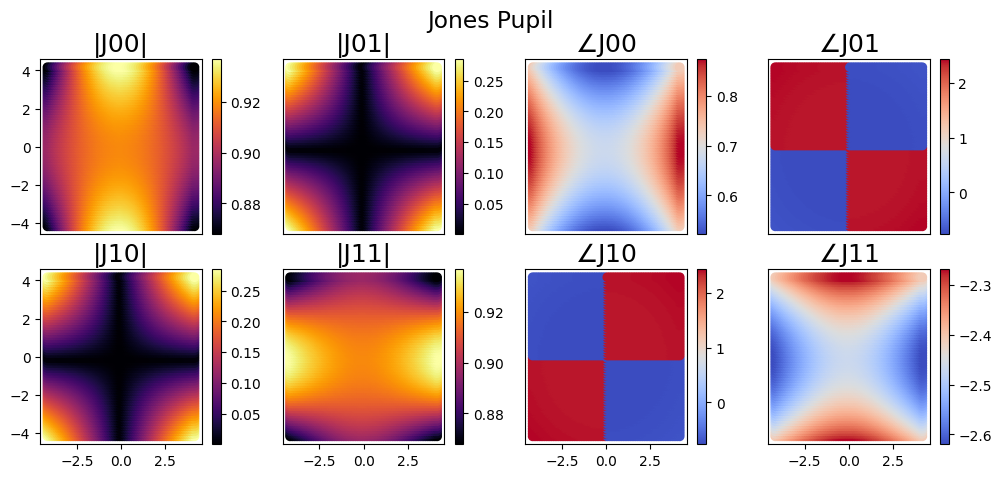

In [10]:
import poke.plotting as plot
rf.compute_jones_pupil()
plot.jones_pupil(rf)

And with a quick scan of our CVUSER directory we can see that there were no files of the type we saved remaining in the directory!

In [13]:
import os
directory_files = os.listdir('C:/CVUSER/')
failed = False
for file in directory_files:
    if (file == 'intermediate_output.txt') or (file == 'intermediate_raytrace.set'):
        failed = True
print(failed)

False
